## Overview
Notebook illustrating performance of a CNN classifier on MNIST dataset compared against generated data by simple GAN(simpGAN) and privGan

In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved. 
# Licensed under the MIT License.

import os
import numpy as np
import pandas as pd
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten, LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from privacygan import privacy_gan as pg
from privacygan.mnist import mnist_gan
from classifier.cnn_classifier import CNNClassifier
import warnings

print(tf.__version__)

#https://github.com/keras-team/keras/wiki/Keras-2.0-release-notes
#https://stackoverflow.com/questions/60289143/migrating-code-to-tensorflow-2-0-gives-invalid-argument-error-default-maxpoolin
tf.keras.backend.set_image_data_format("channels_last")

2.3.0


## Retrieve train and test data from the MNIST dataset

In [2]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
print(X_train.shape)
print(X_test.shape)

NUM_CLASSES = 10

(60000, 784)
(10000, 784)


In [4]:
# CNN model to classify MNIST dataset
y_tr = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_t = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

x_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
x_test = X_test.reshape(X_test.shape[0], 28, 28, 1)


classifier = CNNClassifier(NUM_CLASSES,(28,28,1))
score = classifier.train(x_train,y_tr,256,1,x_test,y_t)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
r_0 = [score[0],score[1]]

235/235 [==============================] - 97s 413ms/step - loss: 0.3100 - accuracy: 0.9041 - val_loss: 0.0741 - val_accuracy: 0.9764
Test loss: 0.07409970462322235
Test accuracy: 0.9764000177383423


## Using SimpGan generate synthetic images 

In [5]:
#generate simple synthetic images of same size as X_train with same balance
X_c = []
y_c = []

for i in range(NUM_CLASSES):
    print(i)
    In = np.where(y_train==i)
    X = X_train[In]
    tf.keras.backend.clear_session()
    optim = Adam(lr=0.0002, beta_1=0.5)
    gen = pg.MNIST_Generator(optim=optim)
    dis = pg.MNIST_Discriminator(optim=optim)
    
    #learn generator per digit 
    (generator, _, _, _) = pg.SimpGAN(X, generator = gen, discriminator = dis, 
                                      optim = optim, 
                                      epochs = 1, batchSize = 256)
    
    noise = np.random.normal(0, 1, size=[len(X), 100])
    X_c += [generator.predict(noise)]
    y_c += [i]*len(X)
    
X_c = np.concatenate(X_c)    
y_c = np.array(y_c)


## Shuffle labels around
arr = np.arange(len(X_c))
np.random.shuffle(arr)
X_c = X_c[arr]
y_c = y_c[arr]

0
Epochs: 1
Batch size: 256
Batches per epoch: 23.13671875
epoch = 1/1, d_loss=0.549, g_loss=0.753                                                                                                                    
1
Epochs: 1
Batch size: 256
Batches per epoch: 26.3359375
epoch = 1/1, d_loss=0.566, g_loss=0.723                                                                                                                    
2
Epochs: 1
Batch size: 256
Batches per epoch: 23.2734375
epoch = 1/1, d_loss=0.551, g_loss=0.748                                                                                                                    
3
Epochs: 1
Batch size: 256
Batches per epoch: 23.94921875
epoch = 1/1, d_loss=0.554, g_loss=0.741                                                                                                                    
4
Epochs: 1
Batch size: 256
Batches per epoch: 22.8203125
epoch = 1/1, d_loss=0.562, g_loss=0.731                                             

In [6]:
# CNN model to classify SimpGan generated images
y_tr = tf.keras.utils.to_categorical(y_c, NUM_CLASSES)
y_t = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)



x_train = X_c.reshape(X_c.shape[0], 28, 28, 1)
x_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

classifier = CNNClassifier(NUM_CLASSES,(28,28,1))
score = classifier.train(x_train,y_tr,256,1,x_test,y_t)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

r_1 = [score[0],score[1]]

235/235 [==============================] - 100s 424ms/step - loss: 0.1483 - accuracy: 0.9529 - val_loss: 5.7761 - val_accuracy: 0.7131
Test loss: 5.776065826416016
Test accuracy: 0.713100016117096


## Using privGan generate synthetic images

In [7]:
#generate simple synthetic images of same size as X_train with same balance with privGan
X_c2 = []
y_c2 = []

for i in range(NUM_CLASSES):
    print(i)
    In = np.where(y_train==i)
    X = X_train[In]
    tf.keras.backend.clear_session()
    optim = Adam(lr=0.0002, beta_1=0.5)
    generators = [mnist_gan.MNIST_Generator(optim = Adam(lr=0.0002, beta_1=0.5)),
                  mnist_gan.MNIST_Generator(optim = Adam(lr=0.0002, beta_1=0.5))]
    discriminators = [mnist_gan.MNIST_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))
                      ,mnist_gan.MNIST_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))]
    pDisc = mnist_gan.MNIST_DiscriminatorPrivate(OutSize = 2, 
                                          optim = Adam(lr=0.0002, beta_1=0.5))
    
    (generators, _, _, _, _, _)= pg.privGAN(X, epochs = 1, 
                                                                               disc_epochs=1,
                                                                               batchSize=256,
                                                                               generators = generators, 
                                                                               discriminators = discriminators,
                                                                               pDisc = pDisc,
                                                                               optim = optim,
                                                                               privacy_ratio = 1.0)    
    
    noise1 = np.random.normal(0, 1, size=[len(X)//2, 100])
    noise2 = np.random.normal(0, 1, size=[len(X)//2, 100])
    X_c2 += [generators[0].predict(noise1)]
    X_c2 += [generators[1].predict(noise2)]
    y_c2 += [i]*(len(noise1) + len(noise2))
    
X_c2 = np.concatenate(X_c2)    
y_c2 = np.array(y_c2)

0
24/24 [==============================] - 2s 91ms/step - loss: 0.7663 - val_loss: 0.6843
dp-Accuracy: 0.5537734256289043
Epochs: 1
Batch size: 256
Batches per epoch: 11
epoch = 0/1, batch = 10/11                                                                                                     
dLosses = [0.44798338 0.43747817]
dpLosses = 0.0
gLosses = 2.780775850469416
dp-Accuracy: 0.0
1
27/27 [==============================] - 3s 95ms/step - loss: 0.7586 - val_loss: 0.6925
dp-Accuracy: 0.519430436072382
Epochs: 1
Batch size: 256
Batches per epoch: 13
epoch = 0/1, batch = 12/13                                                                                                     
dLosses = [0.45303324 0.45078788]
dpLosses = 0.0
gLosses = 2.801565463726337
dp-Accuracy: 0.0
2
24/24 [==============================] - 2s 90ms/step - loss: 0.7784 - val_loss: 0.7062
dp-Accuracy: 0.501007049345418
Epochs: 1
Batch size: 256
Batches per epoch: 11
epoch = 0/1, batch = 10/11                      

In [8]:
## Shuffle labels around
arr = np.arange(len(X_c2))
np.random.shuffle(arr)
X_c2 = X_c2[arr]
y_c2 = y_c2[arr]

In [9]:
#train CNN model for images created by privGan
y_tr = tf.keras.utils.to_categorical(y_c2, NUM_CLASSES)
y_t = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

x_train = X_c2.reshape(X_c2.shape[0], 28, 28, 1)
x_test = X_test.reshape(X_test.shape[0], 28, 28, 1)



classifier = CNNClassifier(NUM_CLASSES,(28,28,1))
score = classifier.train(x_train,y_tr,256,1,x_test,y_t)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
r_2 = [score[0],score[1]]


235/235 [==============================] - 99s 420ms/step - loss: 0.2608 - accuracy: 0.9241 - val_loss: 25.0063 - val_accuracy: 0.3319
Test loss: 25.006332397460938
Test accuracy: 0.3319000005722046


Text(0, 0.5, 'Accuracy')

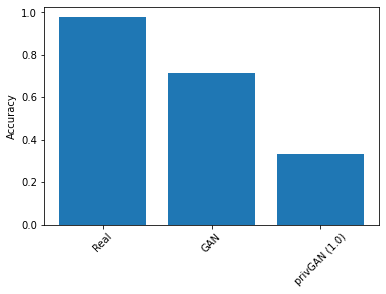

In [10]:
plt.bar([0,1,2],[r_0[1],r_1[1],r_2[1]])
plt.xticks([0,1,2],['Real','GAN','privGAN (1.0)'], rotation=45)
plt.ylabel('Accuracy')